# PHY4268 Tutorial 3 - Qiskit VQE

1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
       
May 2024

$
\newcommand{\ad}{a^\dagger} % Operateur bosonique adjoint 
\newcommand{\mt}[1]{\mathtt{#1}} %  Use mathtt
\newcommand{\mel}[3]{\langle #1|#2|#3\rangle} %Matrix element
\newcommand{\ket}[1]{|#1\rangle}
$

 L'objectif de ce tutoriel 3 est de présenter brièvement l'algorithme VQE (Variational Quantum Eigensolver), dans la contexte de la chimie quantique ou de la modélisation moléculaire. Le VQE utilise la méthode variationelle, et deux processeurs, quantique et classique, pour déterminer l'énergie la plus basse associée à la valeur propre de l'etat fondamental ou des états excités.

 A la fin de ce tutoriel, l'apprenant doit être capable d'utiliser Qiskit-Nature pour
 * renseigner la structure de la molécule et obtenir `ElectronicStructureProblem`;
 * obtenir les Hamiltoniens de 1ere et 2e quantification;
 * transformer le Hamiltoniens de 2e quantification en Hamiltonien de spin;
 * exploiter la symétrie $\mathbb{Z}_2$ pour effectuer la **reduction 2-qubit**;
 * evaluer l'énergie en utilisant le VQE.

 


## Algorithme détaillé du VQE

On peut résumer cet algorithme en deux grandes parties qu'illustre la figure ci-dessous.

![VQE_Flowchart](./Graphics/VQE_Flowchart_Tuto3.jpeg)
                                                          
### Processeur quantique

Le processeur quantique comporte trois étapes fondamentales :

1. Définir le circuit quantique ou porte quantique $\mathtt{U}(\vec{\theta})$;
2. Préparer de la fonction d'essai paramétré $|\Psi (\vec{\theta})\rangle$ appelée **Ansatz**, qui est essentiellement une estimation de l'état fondamental, à cet effet, on choisit arbitrairement un état de référence $|\psi_0\rangle$ sur lequel on applique $\mathtt{U}(\vec{\theta})$,
	\begin{equation}
		|\Psi (\vec{\theta})\rangle= \mathtt{U}(\vec{\theta})|\psi_0 \rangle=\sum_i\alpha_i|E_i\rangle.
	\end{equation}
3. Mesurer de la valeur moyenne ou fonction de coût
\begin{equation}
C(\vec\theta)=\langle\Psi(\vec\theta)|\mathtt{H}|\Psi(\vec\theta)\rangle
=\langle \psi_0| \mathtt{U}^\dagger (\vec{\theta})\mathtt{HU} (\vec{\theta})|\psi_0\rangle.
\end{equation}
Selon la décomposition spectrale, $\mathtt{H}$ peut être représenté par:
\begin{equation}
\mathtt{H}=\sum_i E_i|E_i\rangle\langle E_i|.
\end{equation}
En vertu du [théorème variationnel](https://en.wikipedia.org/wiki/Vcorrespondariational_method_(quantum_mechanics)) de Rayleigh-Ritz, la valeur moyenne est toujours supérieure ou égale à la valeur propre $E_0$ la plus basse de l'Hamiltonien $\mathtt{H}$, qui correspond à l'état fondamental $|E_{\min}\rangle$:
\begin{equation}
C(\vec\theta)=\langle \psi_0| \mathtt{U}^\dagger (\vec{\theta})\mathtt{HU} (\vec{\theta})|\psi_0\rangle
=\sum_i|\alpha_i|^2E_i\geq E_{\min}.
\end{equation}
Le problème se résume à trouver un tel choix optimal de paramètres $\vec\theta=(\theta_1,\dots,\theta_n)^T$ à valeurs réelles, permettant de trouver la valeur moyenne minimale $E_{\min}$ qui est l'énergie de l'état fondamental et l'état correspondant est l'état fondamental $|E_{\min}\rangle$.


### Processeur classique

Grâce au processeur quantique, on obtient une valeur moyenne dépendante des paramètres. Cette valeur peut être minimisée avec une méthode d'optimisation qui permet d'ajuster les paramètres de l'état d'essai. L'algorithme procède alors de façon itérative, l'optimiseur classique proposant de nouvelles valeurs de paramètres pour l'état d'essai.

En gros, dans le processeur classique :
1. Minimiser la valeur moyenne ou fonction de coût $C(\vec\theta)$ en faisant varier les paramètres $\vec{\theta}$ de l'_Ansatz_, en utilisant un optimiseur classique.
2. Itèrer jusqu'à ce que le critère de convergence ($10^{-7}$) soit atteint et que $|\psi(\vec{\theta})\rangle\simeq |E_0(\vec{\theta})\rangle$.


### Défis ou challenges du VQE

1. La taille de l'espace de Hilbert en fonction du nombre des opérations de portes nécessaires ou **profondeur du circuit** pour obtenir le précisions souhaitée pour les valeurs attendues (comme l'énergie du système).

2. Le nombre de portes parametrés (nombre de paramètres à optimiser) en fonction de l'amplitude des gradients pour les variables de circuits.

3. La taille de l'espace de Hilbert en fonction du nombre de mesures nécessaire pour parvenir à la convergence des propriétés physiques (par exemple, l'énergie du système).


Dans ce qui suit, nous utilisons les **Unitary Coupled Clusters Singles and Doubles** (UCCSD) comme point de départ pour déterminer une fonction d'état d'essai pour la méthode variationnelle, car il est essentiel que l'ansatz VQE soit proche de l'état fondamental réel pour que les calculs VQE réussissent.

### 1.1.4. <a id='toc1_1_4_'></a>[Unitary Coupled Cluster (UCC) *Ansatz*](#toc0_)

En chimie quantique, la méthode **Unitary Coupled Cluster (UCC)** (de [cluster à couplage unitaire](https://fr.wikipedia.org/wiki/M%C3%A9thode_du_cluster_coupl%C3%A9)) apparait comme une extension de la méthode *Coupled Cluster (CC)* qui est une méthode de traitement de la corrélation électronique. Elle est basée sur l'expression de la fonction d'état à $N$ électrons comme une combinaison linéaire de déterminants de Slater incluant la fonction d'état HF de l'état fondamental et toutes les excitations possibles des orbitales occupées vers des orbitales inoccupées. Ainsi, il sera possible de générer un *Unitary Coupled Cluster Ansatz* en appliquant à un état de référence $\ket{\psi_0}$ un opérateur unitaire qui est une somme anti-Hermitienne d'opérateurs d'excitation et de désexcitation sous la forme $e^{\mathtt{T}(\theta)-\mathtt{T}^\dagger(\theta)}$, qui est un opérateur unitaire
$$
\ket{\psi(\theta)} = \mt{U}(\theta) \ket{\psi_0}
= e^{\mathtt{T}(\theta)-\mathtt{T}^\dagger(\theta)} \ket{\psi_0(\theta)} ,
$$
* $\theta$ est l'amplitude CC. Il représente aussi le paramètre d'optimisation pouvant prendre des valeurs réelles ou imaginaires. Mais les paramètres réels se sont révélés plus précises et plus réalisables ;

* $\mathtt{T}(\theta)$ est l'opérateur de *Cluster* ou opérateur d'excitation complète, défini comme  $\mathtt{T}(\theta)=\sum_{k=1}^N\mathtt{T}_k(\theta)$ avec $\mathtt{T}_k(\theta)$ l'opérateur d'excitation au $k$-ième ordre, qui contient des termes $k$-corps. Par exemple,
    * l'opérateur 
\begin{equation*}
\mathtt{T}_1 = \underset{i\in\rm{unocc}}{\sum_{j\in\rm{occ}}}\theta_{ij}\ad_i a_j,
\end{equation*}  
engendre les **excitations simples** $j\rightarrow i$ (transforme le déterminant HF de référence en une combinaison linéaire des déterminants monoexcités),
    * l'opérateur
 \begin{equation*}
\mathtt{T}_2 = \underset{l>k\in\rm{occ}}{\sum_{i>j\in\rm{unocc}}}\theta_{ijkl} 
\ad_i\ad_j a_k a_l,\ \dots,
\end{equation*}  
engendre les **doubles excitations** (transforme le déterminant HF de référence en une combinaison linéaire des déterminants doublement excités).
    * Les termes d'ordre supérieur (triple, quadruple, etc.) sont possibles, mais sont actuellement rarement pris en charge par les bibliothèques de chimie quantique.
    * "occ" et "unocc" sont définis comme les sites occupés et les sites inoccupés dans l'état de référence.
    * Les opérateurs $\ad_i$ et $a_i$ dans les termes de clusters couplés ci-dessus sont écrits dans une forme canonique, dans laquelle chaque terme est en ordre normal (opérateurs de création sont à gauche de tous les opérateurs d'annihilation).

## Choix des optimiseurs classiques

Une fois que l'_Ansatz_ a été sélectionné, ses paramètres doivent être optimisés pour minimiser la valeur attendue de l'Hamiltonien cible. Le processus d'optimisation des paramètres présente divers défis. Par exemple, le matériel quantique a divers types de bruits et donc l'évaluation de la fonction objective (calcul de l'énergie) peut ne pas nécessairement refléter la véritable fonction objectif. De plus, certains optimiseurs effectuent un certain nombre d'évaluations de fonctions objectives en fonction de la cardinalité de l'ensemble de paramètres. __Un optimiseur approprié doit être sélectionné en tenant compte des exigences d'une application__.

- Un optimiseur approprié pour optimiser une fonction objectif bruyante est l'optimiseur d'__approximation stochastique de perturbations simultanées (Simultaneous Perturbation Stochastic Approximation, SPSA),__ (`qiskit.algorithms.optimizers.SPSA`). SPSA se rapproche du gradient de la fonction objectif avec seulement deux mesures. Il le fait en perturbant simultanément tous les paramètres de manière aléatoire, contrairement à la descente de gradient où chaque paramètre est perturbé indépendamment. __Lors de l'utilisation de VQE dans un simulateur bruyant (QasmSimulator) ou sur du matériel réel, SPSA est recommandé comme optimiseur classique__.
    - L'optimiseur Quantum Natural SPSA, QN-SPSA (`qiskit.algorithms.optimizers.QnSPSA`) basé sur SPSA tente d'améliorer la convergence en échantillonnant le gradient naturel au lieu du gradient de premier ordre. Par rapport aux gradients naturels, qui nécessitent $\mathcal{O}(d^2)$ évaluations des valeurs moyennes pour un circuit avec $d$ paramètres, QN-SPSA ne nécessite que $\mathcal{O}(1)$ et peut donc accélérer considérablement le calcul du gradient naturel en sacrifiant une certaine précision. Par rapport à SPSA, QN-SPSA nécessite 4 évaluations supplémentaires de la fidélité.

- Lorsque le bruit n'est pas présent dans l'évaluation de la fonction de coût, comme lors de l'utilisation de VQE avec un simulateur de vecteur d'état (_StatevectorSimulator_), une grande variété d'optimiseurs classiques peut être utile. Par exemple,  
    - l'optimiseur __Constrained Optimization by Linear Approximation, COBYLA,__ (`qiskit.algorithms.optimizers.COBYLA`) qui n'effectue qu'une seule évaluation de fonction objectif par itération d'optimisation, et donc le nombre d'évaluations est indépendant de la cardinalité de l'ensemble de paramètres. Par conséquent, si la fonction objectif est sans bruit et qu'il est souhaitable de minimiser le nombre d'évaluations effectuées, il est recommandé d'essayer COBYLA;
    - l'optimiseur __Programmation des moindres carrés séquentiels (Sequential Least Squares Programming, SLSQP)__ (`qiskit.algorithms.optimizers.SLSQP`), est idéal pour les problèmes mathématiques pour lesquels la fonction objectif et les contraintes sont deux fois continûment différentiables;
    - l'optimiseur __Limited-memory Broyden-Fletcher-Goldfarb-Shanno Bound, L_BFGS_B,__ (`qiskit.algorithms.optimizers.L_BFGS_B`), est une méthode quasi-Newton qui commence par une estimation initiale de la valeur optimale et procède de manière itérative pour affiner cette estimation avec une séquence de meilleures estimations.

### Workflow du VQE

![Qiskit-nature flowchart](./Graphics/Qiskit_nature_Flow.png)

1. Renseigner la structure de la molécule en utilisant la classe `qiskit_nature.second_q.drivers.PySCFDriver`.

2. Effectuer le calcul HF dans la base chimique indiquée. Il s'agit en réalité représenter le problème de l'equation de Schrödinguer électronique, $\mathtt{H}_{\rm el}|\Psi\rangle = E_{\rm el}|\Psi\rangle$. $\mathtt{H}_{\rm el}$ est l'Hamiltonien de la classe `qiskit_nature.second_q.hamiltonians.ElectronicEnergy`. Celle-ci est obtenue à travers la méthode `hamiltonian` de `ElectronicStructureProblem` (voir le Tutoriel 2).

3. Extraire, à l'aide du calcul HF précédent (première quantification), les éléments de matrice 1-integrals $h_{pq}$ et 2-integrals $h_{pqrs}$ qui relient l'Hamiltonien de la seconde quantification 1a celui de la première quantification. Les utiliser pour construire l'Hamiltonien fermionique de la seconde quantification, grâce à la l'attibut `.second_q_op()` du Hamiltonien précédemment obtenu :
\begin{equation}
\mathtt{H} = h_0+\sum_{p,q=1}^M h_{pq}\ad_p a_q + \frac12\sum_{p,q,r,s=1}^M h_{pqrs}\ad_p \ad_q a_ra_s ,
\end{equation} 
que `qiskit_nature.second_q.mappers` converti, grâce à un encodage approprié (JWT, PT ou BKT) en Hamiltonien qubit.

   * Exploiter les symmétries, en utilisant (`qiskit_nature.second_q.mappers.TaperedQubitMapper`),
   \begin{align}
   &[\mathtt{H},\mathtt{N_\uparrow}] = [\mathtt{H},\mathtt{N_\downarrow}] = 0, 
   && \mathtt{N_\uparrow} = \sum_{p=1}^{M/2} \alpha^\dagger_p \alpha_p,
   & \mathtt{N_\downarrow} = \sum_{p=M/2+1}^M \alpha^\dagger_p \alpha_p,
   \end{align}
   pour effectuer la **reduction 2-qubit** (une pour chaque symétrie $\mathbb{Z}$ de l'Hamiltionien) sans modifier la partie inférieure du spectre d'énergie (y compris l'état fondamental). $\mathtt{N_\downarrow}$ et $\mathtt{N_\uparrow}$ sont les opérateurs nombre de particules de spin down et up.

4. La fonction d'état d'essai ou *Ansatz* $\ket{\psi(\theta)}$ est généré à partir de l'état HF $\ket{\Phi_0}$ en appliquant les opérateurs de clusters q-UCC ou autre forme d'*Ansatz* variationnel (`qiskit_nature.second_q.circuit.library.UCCSD`).

5. Evaluer l'énergie du système $\mel{\psi(\theta)}{\mathtt{H}}{\psi(\theta)}$ en utilisant
   * la primitive (ou calcul de la valeur moyenne) `qiskit.primitives.Estimator`;
   * l'optimisation des paramètres du circuit (grâce à `qiskit.algorithms.optimizers`), 
   * suivi par la séquence de mesure des propriétés physiques (avec `qiskit_nature.second_q.algorithms.GroundStateEigensolver` si on cherche l'énergie du niveau fondamental). Ceci peut se faire avec ou sans les mesures du bruit.

6. Repeter les étapes (4) et (5) jusqu'à la convergence, en utilisant un optimiseur classique (ceci est une opération interne de `qiskit_nature.second_q.algorithms.GroundStateEigensolver`). Par usage, on fixe le critère de convergence à $10^{-7}$. En effet, il est essentiel que l'*Ansatz* VQE soit proche de l'état fondamental réel pour que les calculs VQE réussissent. Pour obtenir une estimation d'énergie précise de 1 milli-Hartree (mHa), l'*Ansatz* du VQE doit être proche du véritable état fondamental de moins d'un sur un million.

 Nous allons nous intéresser aux molécules suivantes:
$$
\begin{array}{|l|l|l|}\hline
\text{Molécule} & \text{Qubits} & \text{Energie} (\rm{Hartree}) \\\hline
H_2 & 4 & -1.137306 \\\hline
LiH & 12 & -7.882752\\\hline
O_2 &   &    \\\hline
H_2O & 14 & -75.023189 \\\hline
\end{array}
$$

## Molécule H2O

Ici, nous calculons en fait uniquement la partie électronique. Lors de l'utilisation du package Qiskit Nature, l'énergie de répulsion nucléaire sera ajoutée automatiquement pour obtenir l'énergie totale de l'état fondamental.

In [1]:
try:
    import qiskit_nature
except:
    %pip install qiskit-nature[pyscf] -U
    import qiskit_nature
    
qiskit_nature.__version__

'0.7.2'

### Structure électronique

Nous allons renseigner les données de la molécule et effectuer la conversion en créant un Hamiltonien fermionique (problème électronique précisement) qui sera ensuite converti par la transformation de Jordan Wigner, à un Hamiltonien qubit prêt pour le calcul quantique. 

In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver # Nous travaillons avec le driver PySCF

# Renseigner la structure de la molécule 
driver = PySCFDriver(
    atom='''H  0.6746410000 1.2911040000 3.5652750000
    O  0.1014890000 1.9431500000 3.9777450000
    H -0.4085620000 2.3032160000 3.2466410000''',
    basis="sto-3g",
    charge=0,
    spin=0,
)

# Obtenir l'Electronic structure problem
es_problem = driver.run()


### Solveur VQE

Nous devons définir un solveur VQE, qui est l'algorithme par lequel l'état fondamental est calculé (voir le bloc 4 de l'illustration workflow du VQE). A cet effet, il faut trois éléments essentiels :
  1. Une **forme variationnelle ou *ansatz***. Nous utilisons ici l'*ansatz* Unitary Coupled Cluster (UCC). La valeur par défaut est d'utiliser toutes les excitations simples et doubles. Cependant, le type d'excitation (S, D, SD) ainsi que d'autres paramètres peuvent être sélectionnés. La forme variationnelle `qiskit_nature.second_q.circuit.library.UCCSD` est préparée avec un état initial `qiskit_nature.second_q.circuit.library.HartreeFock`, qui initialise l'occupation de nos qubits en fonction du problème que nous essayons de résoudre.
  2. Une primitive, qui sera ici `qiskit.primitives.Estimator` pour le calcul des valeurs moyennes;
  3. Un optimiseur classique (`qiskit_algorithms.optimizers`).

- Configurons l'*ansatz* et plus précisement, le **circuit quantique paramétré**, du VQE

In [3]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, TaperedQubitMapper

mapper = ParityMapper(num_particles=es_problem.num_particles)
# mapper = JordanWignerMapper()
mapper = es_problem.get_tapered_mapper(mapper) # Commenter cette ligne si vous ne voulez faire la reduction Z2 des qubits

HF_state = HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper)

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state = HF_state)

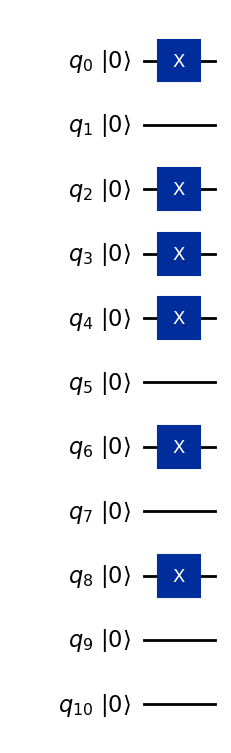

In [4]:
# Visualisation de l'état initial 
ansatz.initial_state.draw('mpl',initial_state=True) # Or aHF_state.draw('mpl',initial_state=True)

- Configurons la primitive `qiskit.primitives.Estimator` du VQE. Elle calcule les valeurs moyennes des circuits d'entrée et des propriétés physiques.

In [5]:
from qiskit.primitives import Estimator

estimator = Estimator()

- Configurons l'optimisseur classique du VQE.

In [6]:
from qiskit_algorithms.optimizers import SLSQP

- Assemblons ces composants de l'algorithme VQE dans `from qiskit_algorithms.VQE` et initialisons le solver VQE.

In [7]:
from qiskit_algorithms import VQE
import numpy as np

vqe_solver = VQE(Estimator(), ansatz, SLSQP())
vqe_solver.initial_point = np.zeros(ansatz.num_parameters) # Initialisation with zero-qubit

### Calcul et résultats

 - Préparons le solveur d'état fondamental et exécutons-le pour calculer l'état fondamental de la molécule grâce à la classe `qiskit_nature.second_q.algorithms.GroundStateEigensolver`. Il s'agit d'envelopper notre `qiskit_nature.second_q.mappers` et notre algorithme quantique `qiskit_algorithms.VQE`  dans un seul `GroundStateEigensolver`. 

Le workflow interne est le suivant :
1. générer les opérateurs de seconde quantification stockés dans notre `problem`" (Electronic Structure Problem);
2. mapper (et potentiellement réduire) les opérateurs dans l'espace qubit;
3. exécuter l'algorithme quantique sur l'opérateur Hamiltonien qubit;
4. une fois le critère de convergence vérifié, évaluer les proprités physiques supplémentaires de l'état fondamental déterminé.

In [8]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

GS_VQE = GroundStateEigensolver(mapper, vqe_solver)

* Resulat VQE

In [9]:
GS_res = GS_VQE.solve(es_problem)
print(GS_res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.170434162962
  - computed part:      -84.170434162962
~ Nuclear repulsion energy (Hartree): 9.15688145023
> Total ground state energy (Hartree): -75.013552712733
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 10.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.03710775  36.16845096  73.00744477]
 
  0: 
  * Electronic dipole moment (a.u.): [None  None  None]
    - computed part:      [None  None  None]
  > Dipole moment (a.u.): [None  None  None]  Total: None
                 (debye): [None  None  None]  Total: None
 


### Calcul classique

Le solveur purement classique `qiskit_algorithms.NumPyMinimumEigensolver` est l'algorithme diagonise exactement l'Hamiltonien. Il peut-être considéré comme équivalent à la méthode Full Configuration Interaction (FCI) et peut donc être utilisé sur de petits systèmes pour vérifier les résultats des algorithmes quantiques.

In [10]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

In [11]:
NP_calc = GroundStateEigensolver(mapper, numpy_solver)
NP_GS_res = NP_calc.solve(es_problem)
print(NP_GS_res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.170535650802
  - computed part:      -84.170535650802
~ Nuclear repulsion energy (Hartree): 9.15688145023
> Total ground state energy (Hartree): -75.013654200573
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 10.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.03710775  36.16845096  73.00744477]
 
  0: 
  * Electronic dipole moment (a.u.): [None  None  None]
    - computed part:      [None  None  None]
  > Dipole moment (a.u.): [None  None  None]  Total: None
                 (debye): [None  None  None]  Total: None
 


* Nous calculons l'erreur absolue entre les deux solvers avec le mapper "PM".

In [12]:
res_exp = -75.023189 # valeur expérimentale?
au2kcalc = 627.503
error_NP = (NP_GS_res.total_energies[0] - res_exp) * au2kcalc
error_VQE = (GS_res.total_energies[0] - res_exp) * au2kcalc
error_HF = (GS_res.hartree_fock_energy - res_exp) * au2kcalc

print(f'\n The absolute error is \n {error_NP:.4f} kcal/mole for Nympy calculations \
      \n {error_VQE:.4f} kcal/mole for VQE calculations\
      \n {error_HF:.4f} kcal/mole for HF calculations')


 The absolute error is 
 5.9831 kcal/mole for Nympy calculations       
 6.0468 kcal/mole for VQE calculations      
 37.3958 kcal/mole for HF calculations


- Améliorons l'affichage des résultats pour des besoins de comparaison.

In [13]:
import pandas as pd

# Create the exact results dataframe
dict_res = {'Reference': [res_exp, ''], 
            'Numpy': [NP_GS_res.total_energies[0], error_NP],
            'VQE': [GS_res.total_energies[0], error_VQE],
            'HF': [GS_res.hartree_fock_energy, error_HF]}
df = pd.DataFrame(dict_res, index = ['E_tot (H)', 'Error (kcal/mol)'])

df

,Reference,Numpy,VQE,HF
E_tot (H),-75.023189,-75.013654,-75.013553,-74.963594
Error (kcal/mol),,5.983115,6.046799,37.395834
